# **Imoports**

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import cv2
import numpy as np
from skimage.segmentation import quickshift
import lime
from lime import lime_image
from sklearn.metrics import accuracy_score, confusion_matrix
import os
import glob
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import shap
from captum.attr import IntegratedGradients, Saliency, DeepLift, GuidedBackprop

# **Dataset Prepration**

In [3]:
class ImageDataset(Dataset):
    def __init__(self, image_dir):
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (112, 112))
        image = image.astype(np.float32) / 255.0
        image = np.stack([image, image, image], axis=0)  
        label = 1  
        
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [4]:
train_dataset = ImageDataset("G:/XAI/preprocessed_images/train_images")
val_dataset = ImageDataset("G:/XAI/preprocessed_images/val_images")

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


# **Define & Train the Model**

In [6]:
class MobileNetV2Model(nn.Module):
    def __init__(self, num_classes=1):
        super(MobileNetV2Model, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.mobilenet.classifier[1] = nn.Linear(self.mobilenet.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.mobilenet(x)
model = MobileNetV2Model(num_classes=1)

c:\Users\yosef\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yosef\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetV2Model(num_classes=1).to(device)

def compute_accuracy(preds, labels):
    return (preds == labels).sum().item() / len(labels)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)  
        outputs = outputs.view(-1)
        labels = labels.view(-1)  
        loss = criterion(outputs, labels.float())  
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            outputs = outputs.view(-1) 
            
            labels = labels.view(-1)  
            
            loss = criterion(outputs, labels.float())
            
            val_loss += loss.item()
            
            preds = torch.sigmoid(outputs) > 0.5
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    
    print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch [1/10]
  Train Loss: 0.6697, Train Accuracy: 58.74%
  Val Loss: 0.7073, Val Accuracy: 51.14%
Epoch [2/10]
  Train Loss: 0.6696, Train Accuracy: 59.53%
  Val Loss: 0.7084, Val Accuracy: 51.73%
Epoch [3/10]
  Train Loss: 0.6708, Train Accuracy: 58.52%
  Val Loss: 0.6621, Val Accuracy: 61.74%
Epoch [4/10]
  Train Loss: 0.6685, Train Accuracy: 59.43%
  Val Loss: 0.6931, Val Accuracy: 53.62%
Epoch [5/10]
  Train Loss: 0.6737, Train Accuracy: 58.42%
  Val Loss: 0.7000, Val Accuracy: 51.83%
Epoch [6/10]
  Train Loss: 0.6680, Train Accuracy: 59.98%
  Val Loss: 0.7697, Val Accuracy: 41.43%
Epoch [7/10]
  Train Loss: 0.6721, Train Accuracy: 58.91%
  Val Loss: 0.6650, Val Accuracy: 61.65%
Epoch [8/10]
  Train Loss: 0.6712, Train Accuracy: 58.27%
  Val Loss: 0.6854, Val Accuracy: 56.39%
Epoch [9/10]
  Train Loss: 0.6722, Train Accuracy: 59.36%
  Val Loss: 0.7405, Val Accuracy: 44.00%
Epoch [10/10]
  Train Loss: 0.6714, Train Accuracy: 58.96%
  Val Loss: 0.6838, Val Accuracy: 58.37%


In [8]:
#Save Trained Model
torch.save(model.state_dict(), "MobileNetV2_model.pth")
model.load_state_dict(torch.load("MobileNetV2_model.pth"))
model.eval()

MobileNetV2Model(
  (mobilenet): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_

# **XAI Techniques**

In [ ]:
torch.cuda.empty_cache()

In [11]:
model = model.to(device)
model.load_state_dict(torch.load("MobileNetV2_model.pth"))
model.eval()
val_iter = iter(val_loader)
inputs, labels = next(val_iter)
test_image = inputs[0:1].to(device)
test_image_np = test_image.cpu().numpy().transpose(0, 2, 3, 1)[0] * 255

## **GradCAM**

In [12]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        def hook_fn_forward(module, input, output):
            self.activations = output.detach()
            
        def hook_fn_backward(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        
        self.forward_hook = target_layer.register_forward_hook(hook_fn_forward)
        self.backward_hook = target_layer.register_backward_hook(hook_fn_backward)
    
    def __call__(self, x):
        try:
            self.model.eval()
            self.model.zero_grad()
            output = self.model(x)
            score = output.mean()
            score.backward()
            
            if self.gradients is None or self.activations is None:
                raise ValueError("Gradients or activations are None. Check if hooks are properly registered.")
            
            weights = torch.mean(self.gradients, dim=[2, 3])
            batch_size, n_channels, height, width = self.activations.shape
            cam = torch.zeros((batch_size, height, width), device=x.device)
            
            for i in range(batch_size):
                for j in range(n_channels):
                    cam[i] += weights[i, j] * self.activations[i, j]
            
            cam = F.relu(cam)
            cam = F.interpolate(cam.unsqueeze(1), size=(112, 112), mode='bilinear', align_corners=False)
            cam = cam.squeeze(1)
            cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-7)
            
            return cam.detach().cpu().numpy()
            
        except Exception as e:
            print(f"Error in GradCAM: {str(e)}")
            return None
        
    def remove_hooks(self):
        self.forward_hook.remove()
        self.backward_hook.remove()


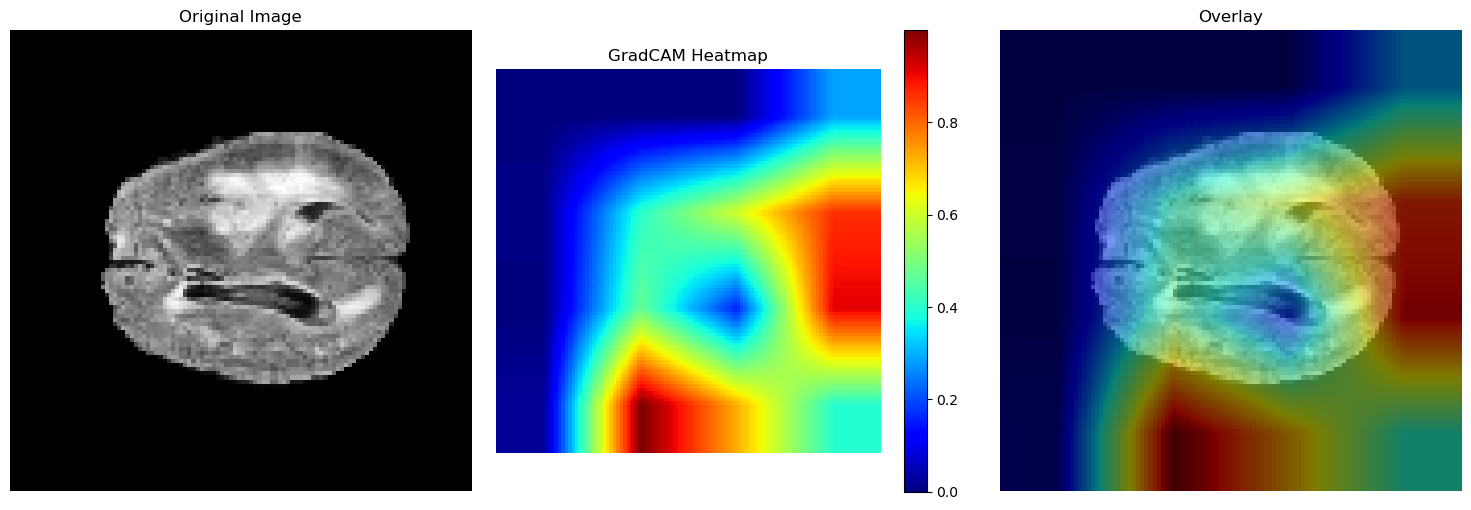

In [ ]:
def visualize_gradcam(model, image, target_layer):
    try:
        grad_cam = GradCAM(model, target_layer)
        
        with torch.set_grad_enabled(True):
            cam_output = grad_cam(image)
        
        grad_cam.remove_hooks()
        
        if cam_output is not None:
            img_display = image.detach().cpu().squeeze().numpy()
            img_display = np.mean(img_display, axis=0)  
            
            plt.figure(figsize=(15, 5))
            
            plt.subplot(131)
            plt.imshow(img_display, cmap='gray')
            plt.title('Original Image')
            plt.axis('off')
            
            plt.subplot(132)
            plt.imshow(cam_output[0], cmap='jet')
            plt.title('GradCAM Heatmap')
            plt.colorbar()
            plt.axis('off')
            
            plt.subplot(133)
            plt.imshow(img_display, cmap='gray')
            plt.imshow(cam_output[0], cmap='jet', alpha=0.5)
            plt.title('Overlay')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
        return cam_output
        
    except Exception as e:
        print(f"Error generating GradCAM visualization: {str(e)}")
        return None

target_layer = model.mobilenet.features[-1]  
torch.cuda.empty_cache()
model.eval()
with torch.no_grad():
    visualize_gradcam(model, test_image, target_layer)

## **Lime**

In [25]:
class LimeExplainer:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.explainer = lime_image.LimeImageExplainer()
    
    def predict_fn(self, images):
        try:
            images = images.astype(np.float32) / 255.0
            if len(images.shape) == 3:
                images = np.expand_dims(images, axis=0)
            batch = torch.FloatTensor(images).permute(0, 3, 1, 2)
            batch = batch.to(self.device)
            with torch.no_grad():
                outputs = torch.sigmoid(self.model(batch)).squeeze()
                if outputs.dim() == 0:
                    outputs = outputs.unsqueeze(0)
                outputs = outputs.cpu().numpy()
            return np.stack([1 - outputs, outputs], axis=1)
        except Exception as e:
            print(f"Error in predict_fn: {str(e)}")
            return None
    
    def explain(self, image):
        try:
            image_np = image.detach().cpu().squeeze().numpy()
            image_np = np.transpose(image_np, (1, 2, 0))
            if image_np.shape[2] == 1:
                image_np = np.repeat(image_np, 3, axis=2)
            def segmentation_fn(img):
                return quickshift(img, kernel_size=4, max_dist=200, ratio=0.2)
            explanation = self.explainer.explain_instance(
                image_np,
                self.predict_fn,
                top_labels=1,
                hide_color=0,
                num_samples=100,
                num_features=50,
                segmentation_fn=segmentation_fn
            )
            temp, mask = explanation.get_image_and_mask(
                explanation.top_labels[0],
                positive_only=True,
                num_features=10,
                hide_rest=False
            )
            return temp, mask
        except Exception as e:
            print(f"Error in explain: {str(e)}")
            return None, None


  0%|          | 0/100 [00:00<?, ?it/s]

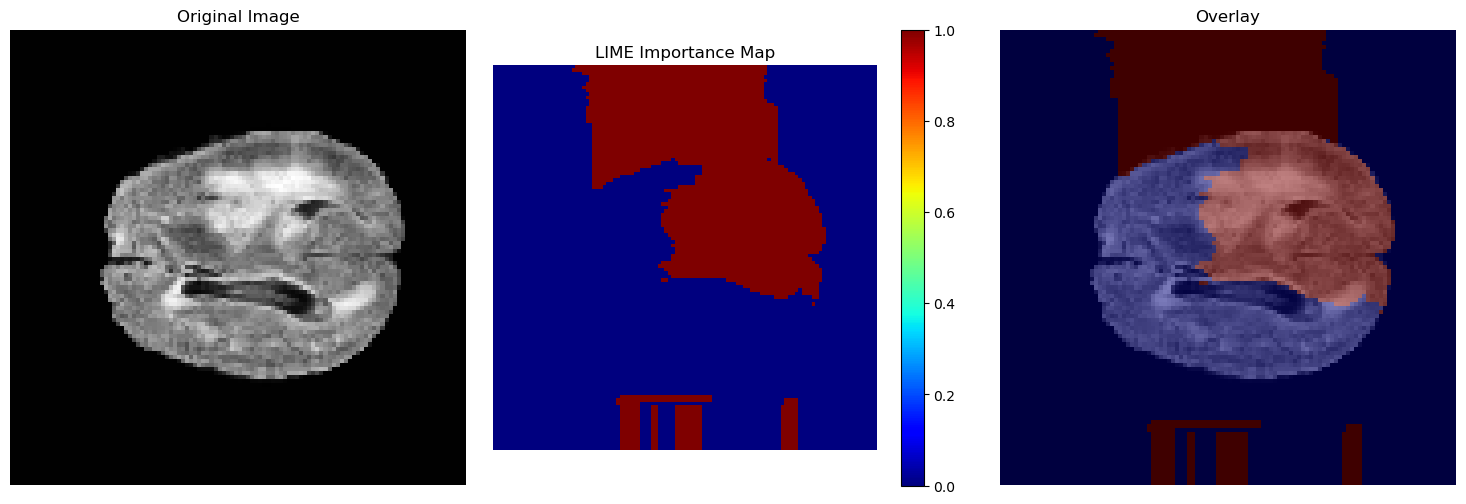

In [26]:
def visualize_lime(model, image, device):
    try:
        lime_explainer = LimeExplainer(model, device)
        temp, mask = lime_explainer.explain(image)
        if temp is not None and mask is not None:
            plt.figure(figsize=(15, 5))
            plt.subplot(131)
            img_display = image.detach().cpu().squeeze().numpy()
            img_display = np.mean(img_display, axis=0)
            plt.imshow(img_display, cmap='gray')
            plt.title('Original Image')
            plt.axis('off')
            plt.subplot(132)
            plt.imshow(mask, cmap='jet')
            plt.title('LIME Importance Map')
            plt.colorbar()
            plt.axis('off')
            plt.subplot(133)
            plt.imshow(img_display, cmap='gray')
            plt.imshow(mask, cmap='jet', alpha=0.5)
            plt.title('Overlay')
            plt.axis('off')
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error in LIME visualization: {str(e)}")

torch.cuda.empty_cache()
model.eval()
with torch.no_grad():
    visualize_lime(model, test_image, device)

## **SHAP**

In [ ]:
class ShapExplainer:
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def batch_predict(self, inputs):
        try:
            batch_size = inputs.shape[0]
            images = inputs.reshape(batch_size, 3, 112, 112)
            batch = torch.FloatTensor(images).to(self.device)
            self.model.eval()
            with torch.no_grad():
                outputs = torch.sigmoid(self.model(batch)).squeeze()
                if outputs.dim() == 0:
                    outputs = outputs.unsqueeze(0)
            return outputs.cpu().numpy()

        except Exception as e:
            print(f"Error in batch_predict: {str(e)}")
            return None

    def explain(self, image, n_samples=10):
        try:
            image_np = image.cpu().squeeze().numpy()  
            image_flattened = image_np.reshape(1, -1) 

            background = np.zeros((n_samples, 112 * 112 * 3))  

            explainer = shap.KernelExplainer(
                model=self.batch_predict,
                data=background,
                link="identity"
            )

            shap_values = explainer.shap_values(
                X=image_flattened,
                nsamples=50,
                l1_reg="num_features(10)"
            )

            return np.array(shap_values).reshape(3, 112, 112)

        except Exception as e:
            print(f"Error in SHAP computation: {str(e)}")
            return None



Computing SHAP values...


  0%|          | 0/1 [00:00<?, ?it/s]

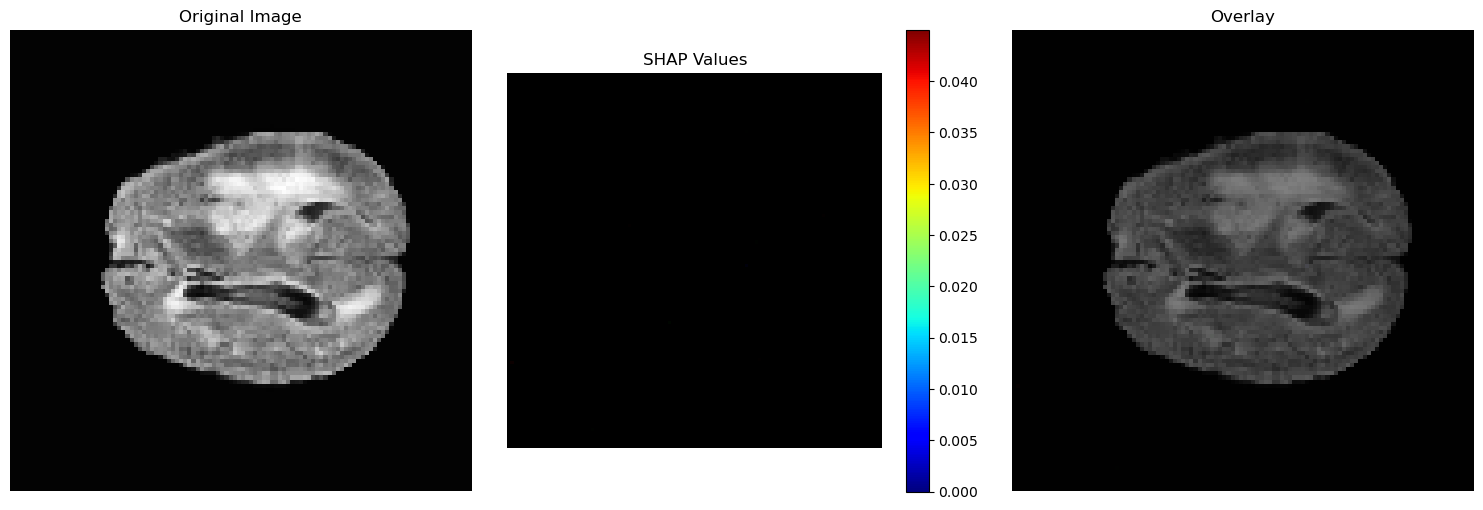

In [37]:
def visualize_shap(model, image, device):
    try:
        print("Computing SHAP values...")
        model = model.cpu()
        image = image.cpu()
        shap_explainer = ShapExplainer(model, "cpu")
        shap_values = shap_explainer.explain(image)

        if shap_values is not None:
            plt.figure(figsize=(15, 5))

            image_np = image.squeeze().numpy()
            if image_np.ndim == 3:
                image_np = np.transpose(image_np, (1, 2, 0))

            shap_np = np.abs(shap_values)
            if shap_np.ndim == 3:
                shap_np = np.transpose(shap_np, (1, 2, 0))

            plt.subplot(131)
            plt.imshow(image_np, cmap='gray' if image_np.shape[-1] == 1 else None)
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(132)
            plt.imshow(shap_np, cmap='jet')
            plt.title('SHAP Values')
            plt.colorbar()
            plt.axis('off')

            plt.subplot(133)
            plt.imshow(image_np, cmap='gray' if image_np.shape[-1] == 1 else None)
            plt.imshow(shap_np, cmap='jet', alpha=0.5)
            plt.title('Overlay')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

        model = model.to(device)

    except Exception as e:
        print(f"Error in SHAP visualization: {str(e)}")
        model = model.to(device)

torch.cuda.empty_cache()
model.eval()
with torch.no_grad():
    visualize_shap(model, test_image, device)

## **Deep Lift**

In [ ]:
class DeepLiftExplainer:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.wrapped_model = self.create_wrapper()
        self.deep_lift = DeepLift(self.wrapped_model)
    
    def create_wrapper(self):
        class WrapperModel(nn.Module):
            def __init__(self, base_model):
                super().__init__()
                self.base_model = base_model
            
            def forward(self, x):
                output = self.base_model(x)
                return output.mean(dim=[2, 3])
        
        return WrapperModel(self.model)
    
    def explain(self, image):
        try:
            baseline = torch.zeros_like(image).to(self.device)
            
            attributions = self.deep_lift.attribute(
                image,
                baseline,
                return_convergence_delta=False
            )
            
            return attributions.squeeze().cpu().detach().numpy()
            
        except Exception as e:
            print(f"Error in DeepLIFT computation: {str(e)}")
            return None

Applying DeepLIFT...
Computing DeepLIFT values...


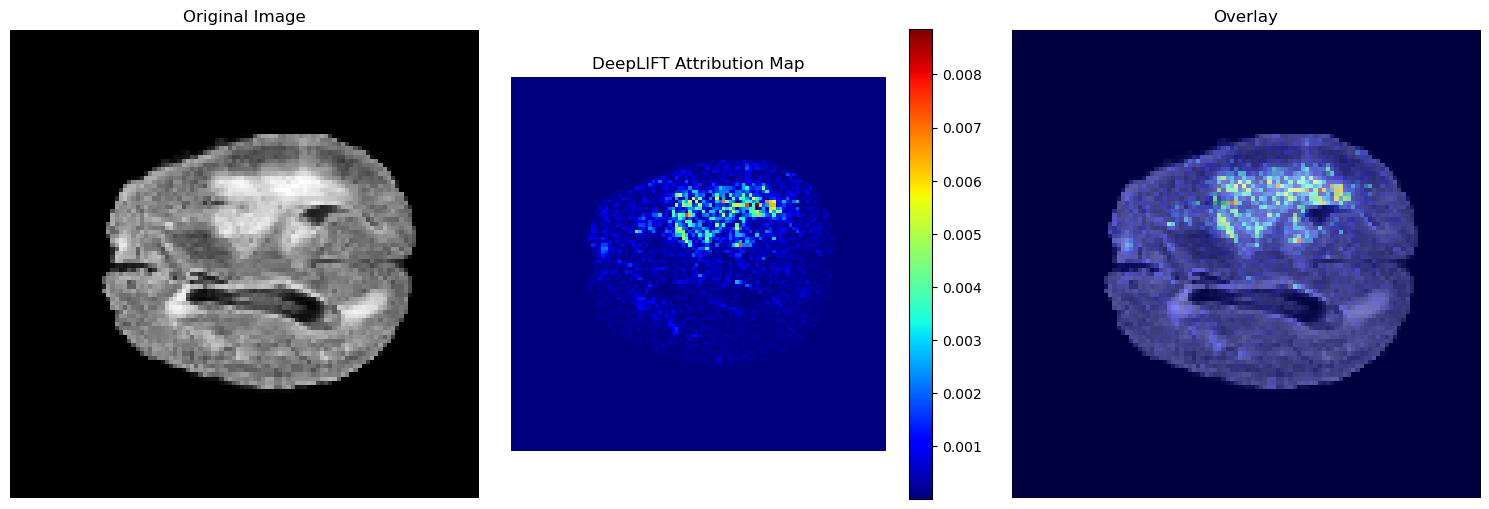

In [ ]:
def visualize_deeplift(model, image, device):
    try:
        print("Computing DeepLIFT values...")
        explainer = DeepLiftExplainer(model, device)
        attributions = explainer.explain(image)
        
        if attributions is not None:
            plt.figure(figsize=(15, 5))
            
            plt.subplot(131)
            plt.imshow(image.cpu().squeeze().numpy(), cmap='gray')
            plt.title('Original Image')
            plt.axis('off')
            
            plt.subplot(132)
            plt.imshow(np.abs(attributions), cmap='jet')
            plt.title('DeepLIFT Attribution Map')
            plt.colorbar()
            plt.axis('off')
            
            plt.subplot(133)
            plt.imshow(image.cpu().squeeze().numpy(), cmap='gray')
            plt.imshow(np.abs(attributions), cmap='jet', alpha=0.5)
            plt.title('Overlay')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
    except Exception as e:
        print(f"Error in DeepLIFT visualization: {str(e)}")

torch.cuda.empty_cache()
model.eval()
with torch.no_grad():
    print("Applying DeepLIFT...")
    visualize_deeplift(model, test_image, device)